# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 04 Spectral subtraction, Wiener filtering, end point detectoin, voice activity detection
2023/04/07

----
### import packages, define analysis parameters and draw parameters, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
import scipy
from scipy import signal
from scipy.fft import fftshift

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# returns decibel, with preventing 0 input
# note: input should be X(w) or x[n]
# dB = 20 log_10 (abs(x)) = 10 log_10 ( x^2 ) 
def decibel_sq_safe(x, epsilon=1e-10):
    return 10*np.log10(np.maximum(np.real(x*np.conj(x)),epsilon))

def drawspectrogram2(x, Nf, Ns=None, winname='hamming', minpercentile=80, isdbscale=True, isdraw=True):
    # Short-time Fourier transform with half-overlap 
    # Nf: analysis size
    # Ns: shift size 
    # NFFT: FFT size, power of 2
    if Ns==None: Ns=Nf//2
    num_frames = (len(x)-Nf)//Ns+1  # 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
    hNo = NFFT//2+1
    X = np.zeros((hNo,num_frames))
    
    # generate window
    if winname=='rect' or winname=='rectangular':
        win = np.ones(Nf)
    else:   # hamming, hann, etc.
        win = librosa.filters.get_window(winname, Nf, fftbins=True)
        
    # STFT
    for i in range(num_frames):
        y = np.fft.fft(win*x[(i*Ns):(i*Ns+Nf)], n=NFFT)
        y = y[:hNo]
        if isdbscale: y = decibel_sq_safe(y)
        else: y = np.abs(y)
        X[:,i] = y

    if isdraw:
        # 상위 80% 정도만 scale 한다. imshow의 vmin vmax 이용 
        vmax = np.max(X[:])
        vmin = np.percentile(X[:], minpercentile)
        specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
        plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis, vmax=vmax, vmin=vmin)
        plt.xlabel('time (seconds)')
        plt.ylabel('frequency (Hz)')
    
    return X

---
### load speech and noise

Speech 와 noise 파일을 정의한다.

In [5]:
speechfile = 'gjang-kdigits0-3.wav'
noisefile  = 'car.wav'

__load an example windows wav file__
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [6]:
# load audio files with Librosa
speech, Fs = librosa.load(speechfile, sr=None, mono='True')
noise, _ = librosa.load(noisefile, sr=Fs, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(speech,speech.shape)
print(noise,noise.shape)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

[-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04] (37952,)
[-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304] (175745,)
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


__generate noisy speech with various SNRs__

In [7]:
mixsnrs = np.array([20, 10, 0, -10])
std_s = np.std(speech)
std_n = np.std(noise)
mixedSig = []
for snr in mixsnrs:
    gain = np.power(10, -snr/20)
    print('SNR = %.0f dB, gain = %.2f' % (snr, gain))
    m = speech + noise[:len(speech)]/std_n*std_s*gain
    mixedSig.append(m)

SNR = 20 dB, gain = 0.10
SNR = 10 dB, gain = 0.32
SNR = 0 dB, gain = 1.00
SNR = -10 dB, gain = 3.16


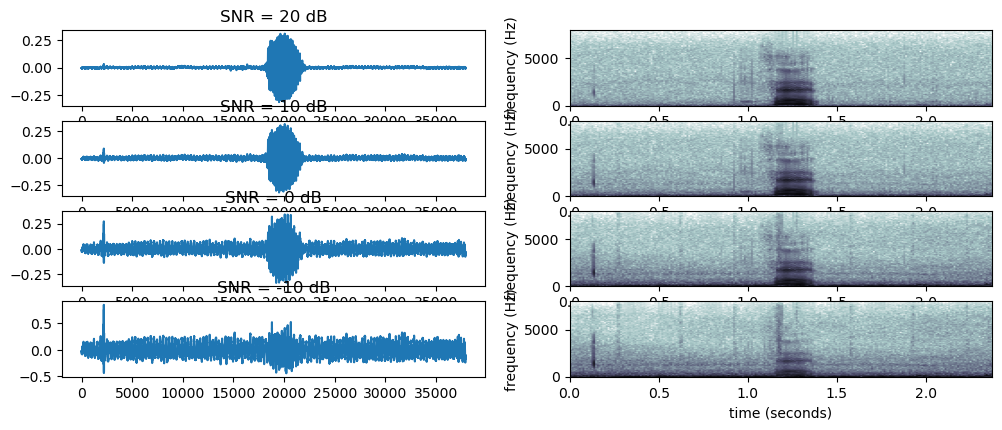

In [8]:
plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))

for m in range(len(mixedSig)):
    plt.subplot(len(mixedSig),2,(m+1)*2-1)
    plt.plot(mixedSig[m])
    plt.title('SNR = %.0f dB' % (mixsnrs[m]))
    plt.subplot(len(mixedSig),2,(m+1)*2)
    drawspectrogram2(mixedSig[m], Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)

Noise spectrum estimation
1. noise 는 stationary, speech 는 non-stationary 가정
2. 처음 0.5~1초는 noise 만 있다고 가정하고 이 구간의 평균 spectral energy ($|\cdot|^2$) 을 추정

In [19]:
# 20 dB mixed speech 에 대하여 잡음 스펙트럼 추정

# getting the noise spectrum
Tn = 0.5   # 0~0.5초
Nn = Tn*Fs
nframes = int((Nn-Nf)//Ns+1)
mix = mixedSig[2]

def getwienerfilter(mix):
    Pnn = np.zeros(hNo)   # n*conj(n)
    for n in range(nframes):
        x = mix[(n*Ns):((n+1)*Ns)]
        X = np.fft.fft(x, NFFT)
        aX2 = (X*np.conj(X))
        Pnn += aX2[:hNo].real
    Pnn = Pnn/nframes

    Hlist = []
    # getting the signal spectrum
    Nn = len(mix)
    nframes2 = int((Nn-Nf)//Ns+1)
    sig = np.zeros(hNo)
    for n in range(nframes2):
        x = mix[(n*Ns):((n+1)*Ns)]
        X = np.fft.fft(x, NFFT)
        aX2 = (X*np.conj(X))[:hNo].real
        sig += aX2
    sig = sig/nframes2

    # getting the Wiener filter
    H = (sig-Pnn)/sig
    for i in range(hNo):
        if H[i]<0.228: H[i]=0.228

    plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))
    plt.plot(Pnn)
    plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))
    plt.plot(sig)
    plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))
    plt.plot(H)
    
    return H

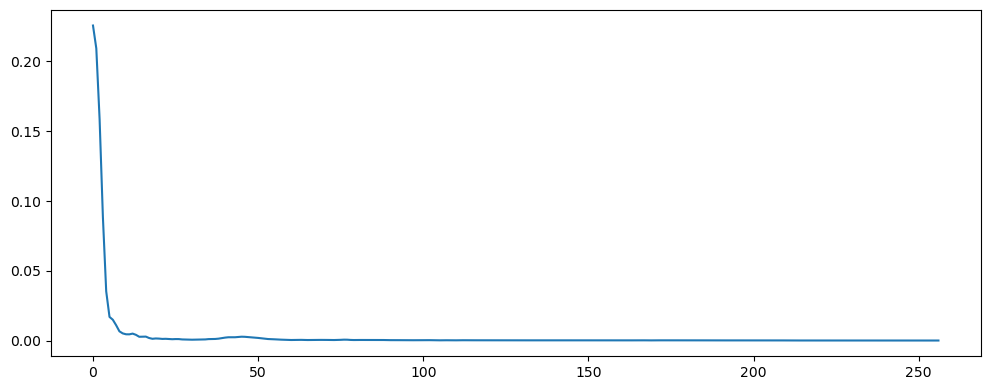

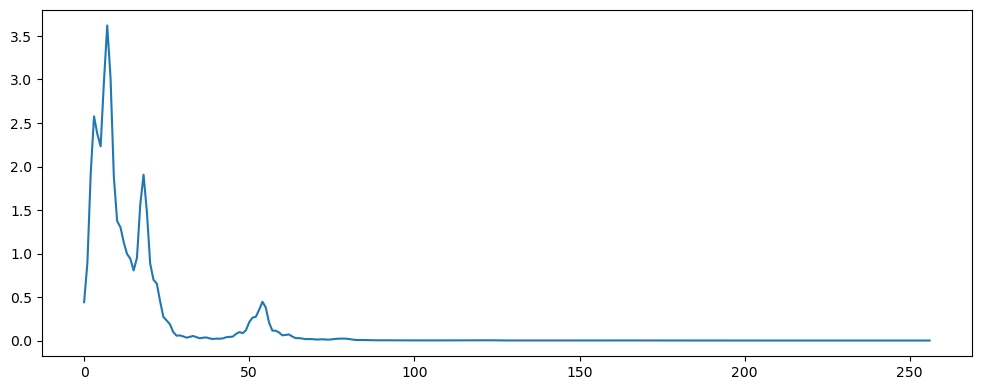

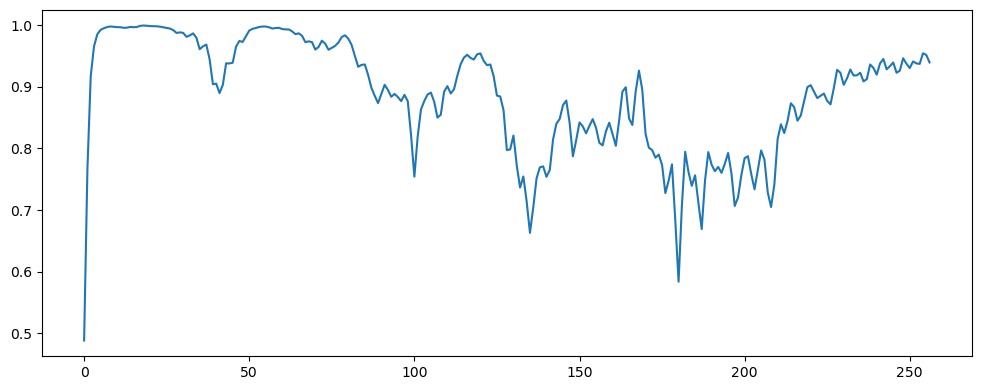

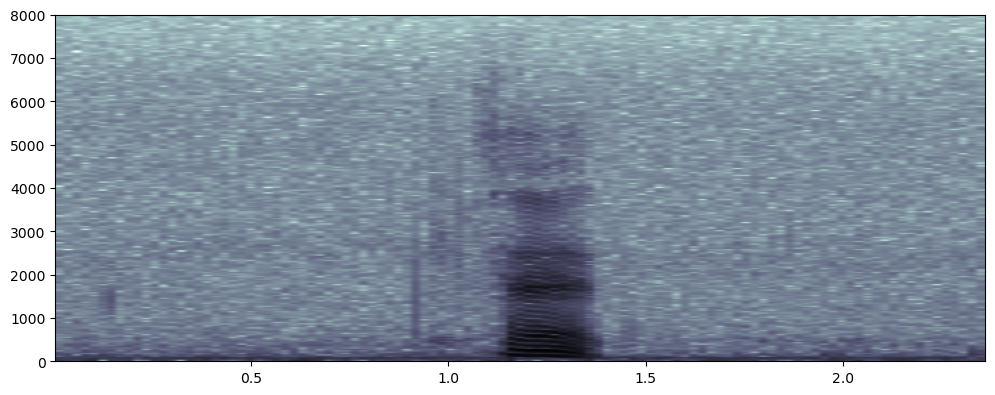

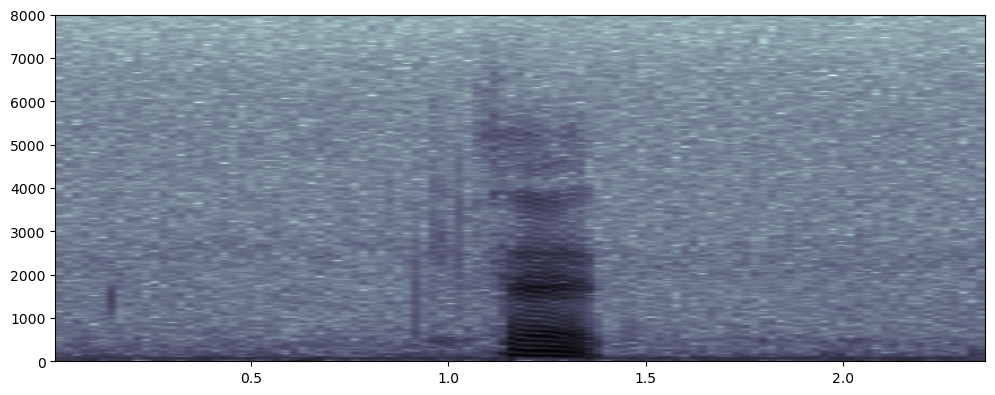

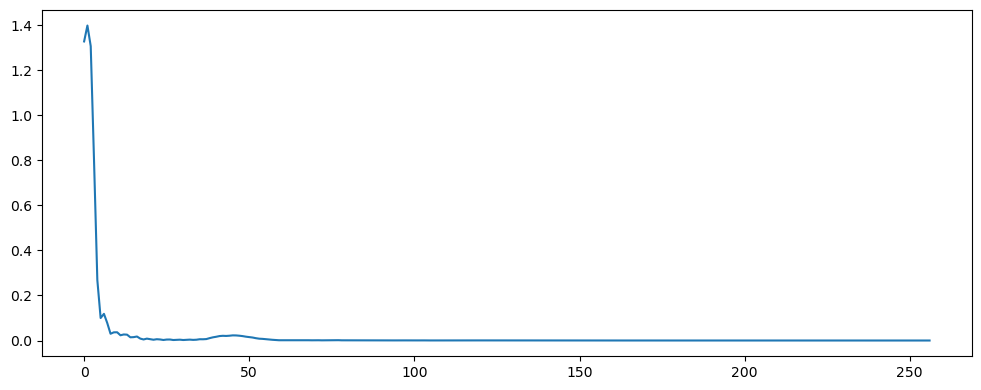

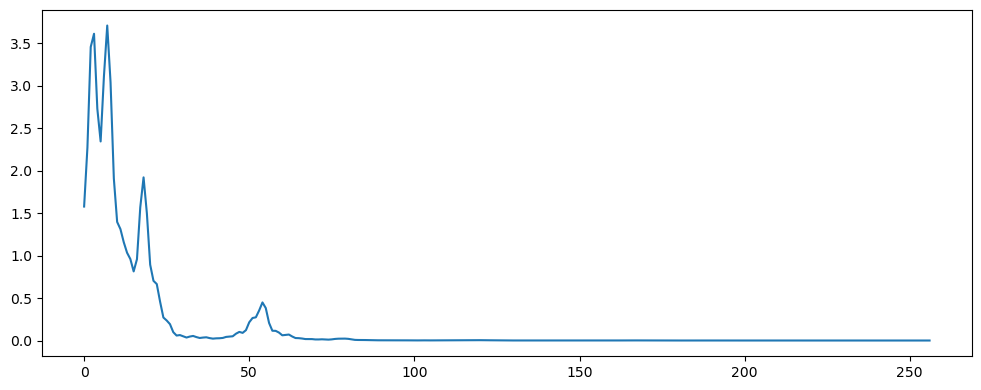

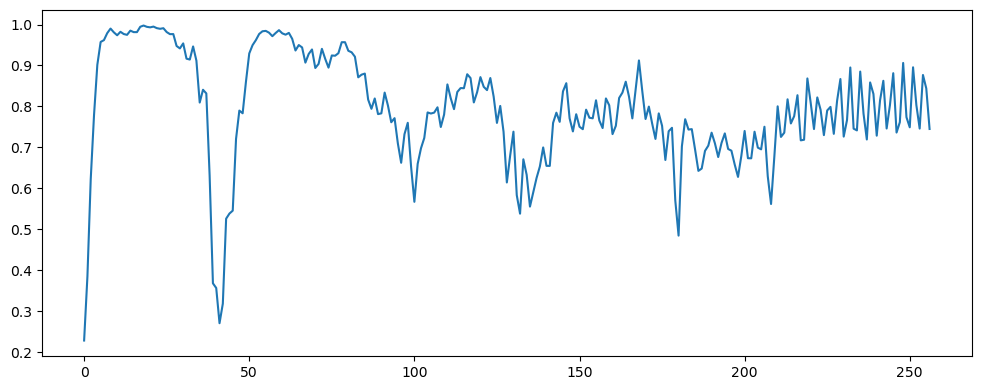

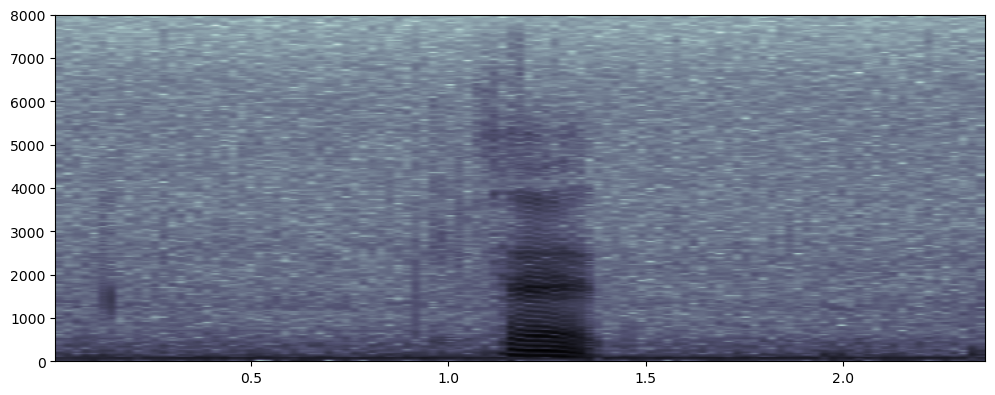

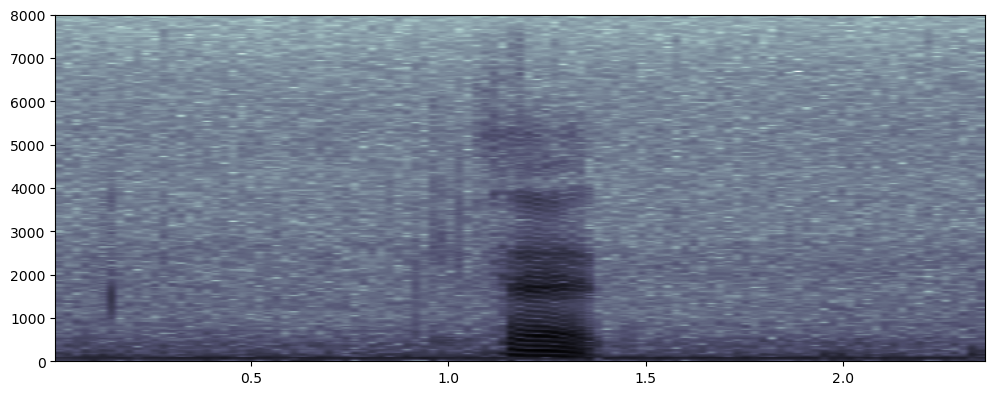

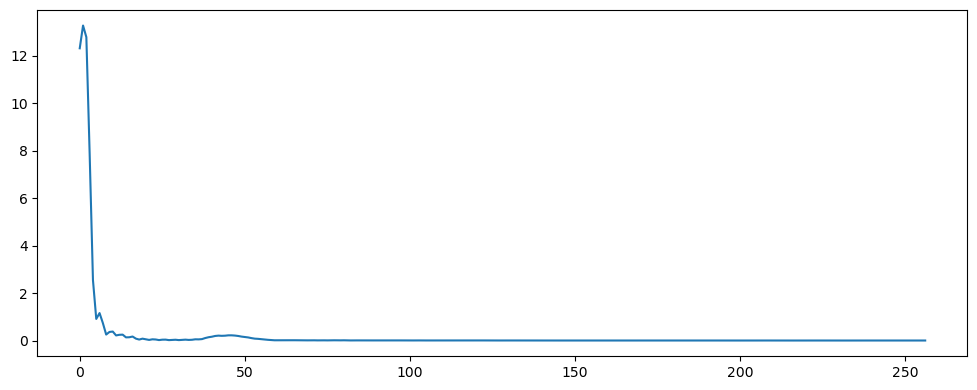

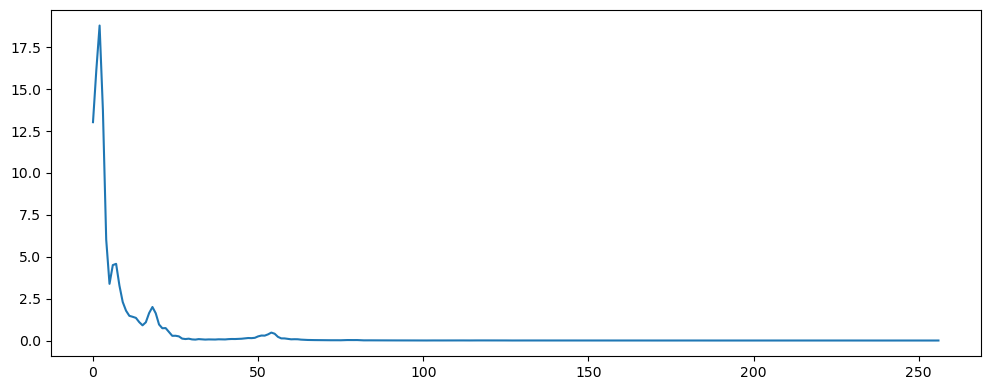

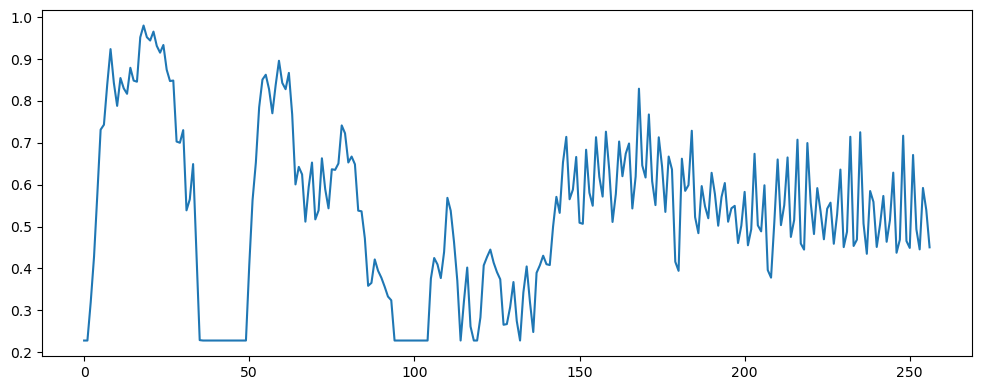

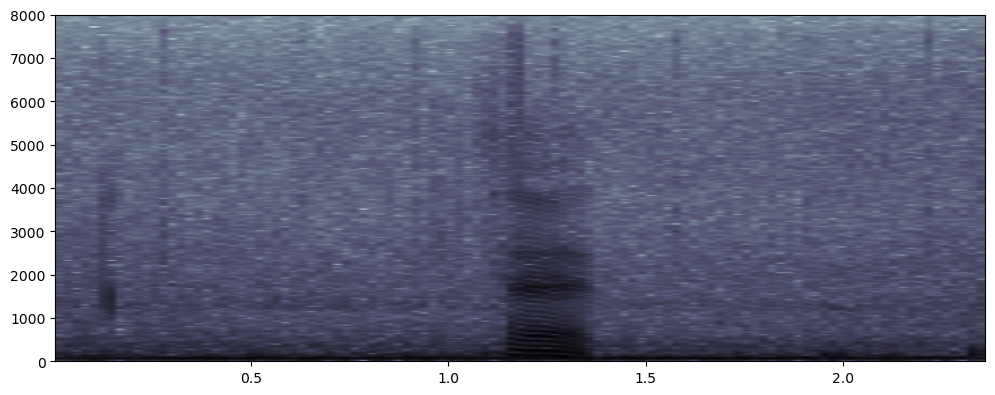

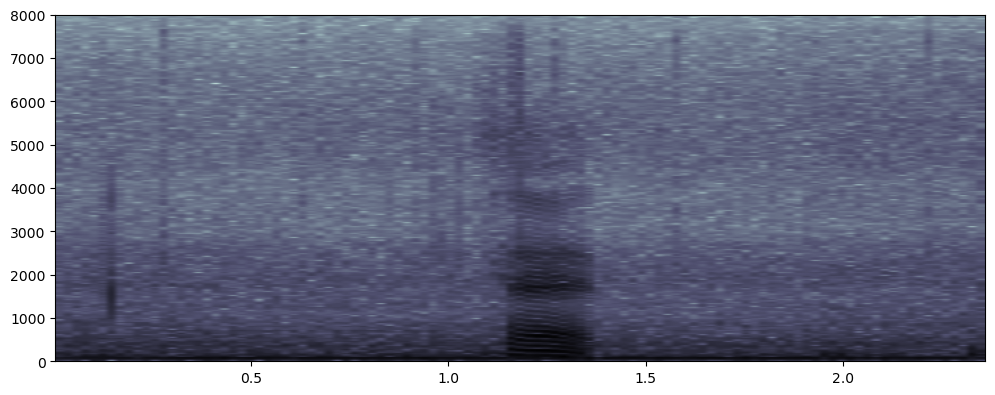

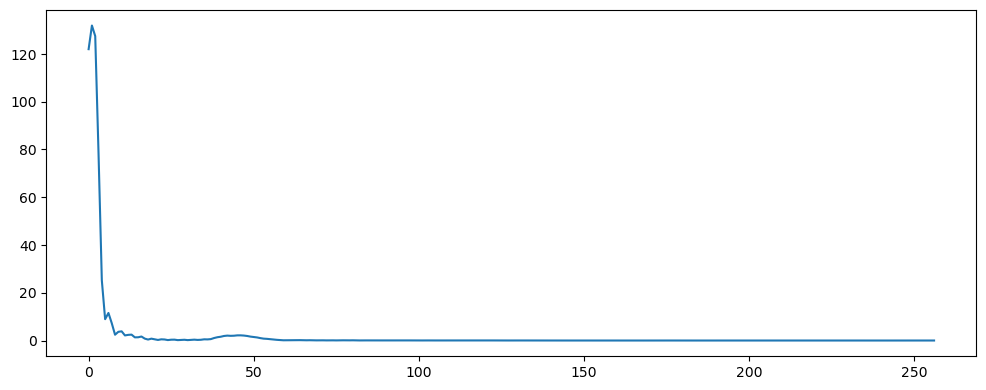

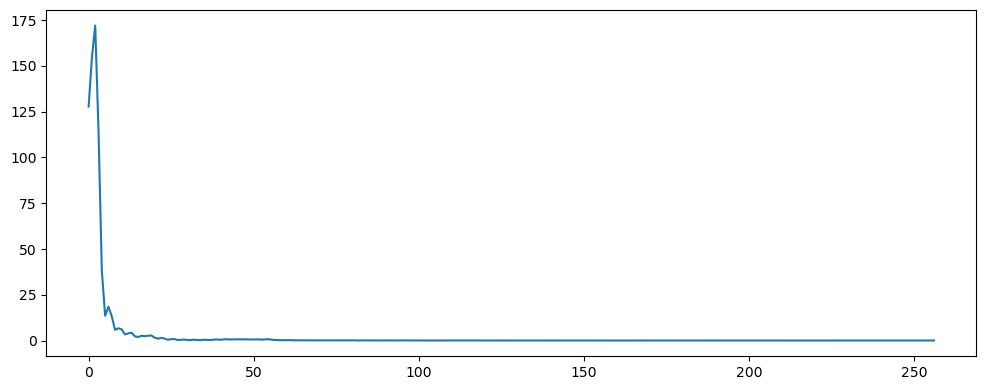

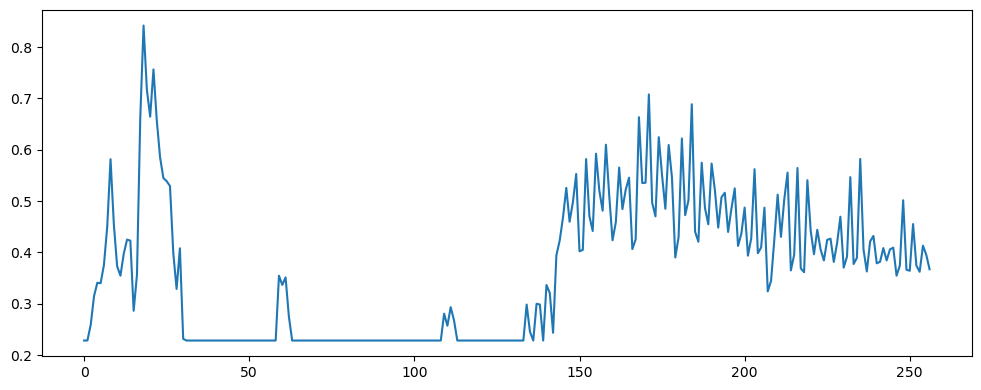

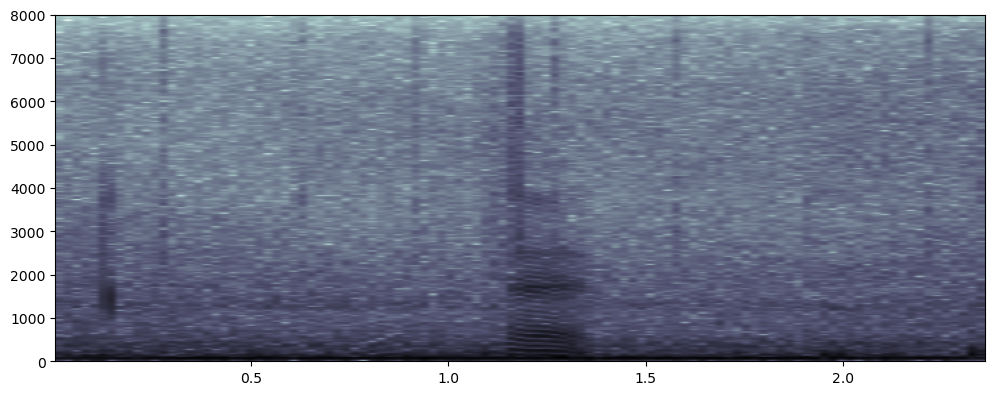

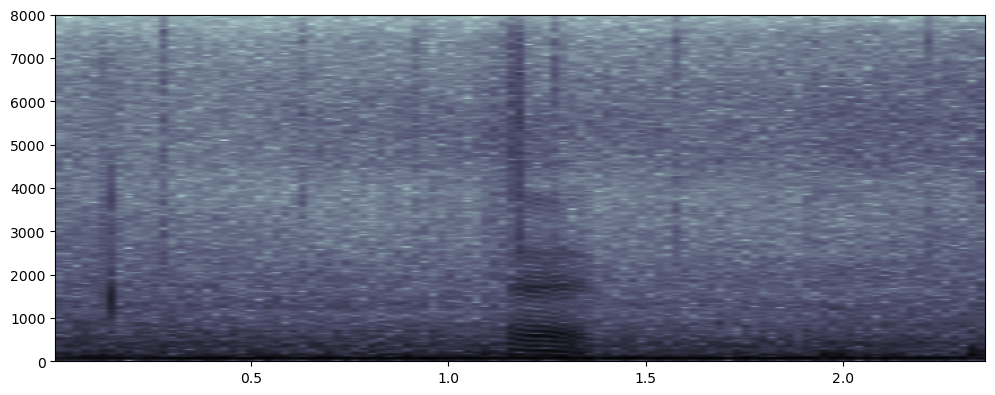

In [10]:
# flip H and concat it with H
def getFIRFFT(H, order, winname=None):
    # H: NFFT/2+1
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    h = np.fft.ifft(H, NFFT)
    order = min(NFFT-1, order)
    #h = np.concatenate((h[len(h)//2:], h[0:len(h)//2]))
    h = np.concatenate((h[(len(h)-order//2):], h[0:order//2+1]))
    if winname != None:
        win = librosa.filters.get_window(winname, order+1, fftbins=False)
        h = h*win
    return h.real

for i in range(len(mixedSig)):
    scipy.io.wavfile.write('mixed_%d.wav'%i, Fs, mixedSig[i])
    H = getwienerfilter(mixedSig[i])
    h = getFIRFFT(H, 64, winname='hamming')
    wav = np.convolve(mixedSig[i], h)
    scipy.io.wavfile.write('filtered_%d.wav'%i, Fs, wav)
    plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))
    plt.specgram(mixedSig[i], NFFT=NFFT, Fs=Fs, noverlap=Nf-Ns, cmap=cmap_plot)
    plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))
    plt.specgram(wav, NFFT=NFFT, Fs=Fs, noverlap=Nf-Ns, cmap=cmap_plot)
    

---
## Programming assignments: spectral subtraction and Wiener filtering, end point detectoin

1. 각각의 SNR에 대해서 잡음을 앞의 0.5 초 구간에서 추정하고 
- cutoff frequency 가 linear하게 올라가는 lowpass filter에 대해서 10ms shift, 3ms overlap의 trapezoidal (사다리꼴 overlap-add) 구현

.

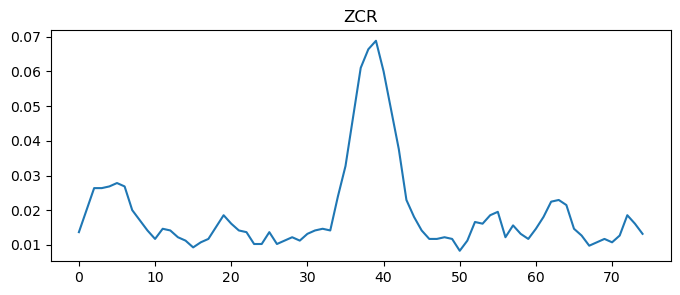

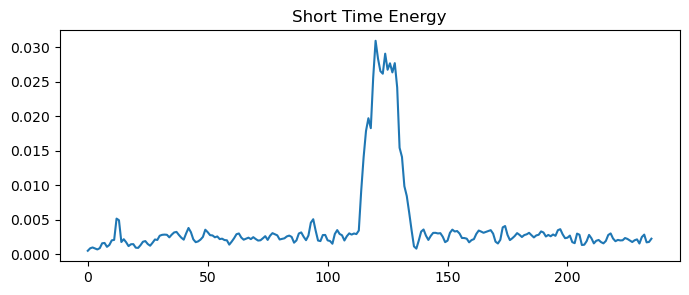

In [20]:
def st_energy(signal, frame_size, hop_size):
    energy = []
    for i in range(0, len(signal) - frame_size, hop_size):
        frame = signal[i:i + frame_size]
        frame_energy = np.sum(np.abs(np.fft.fft(frame, NFFT))**2, axis=-1) / len(frame)**2
        energy.append(frame_energy)
    return energy

signal1 = mix

zcrs = librosa.feature.zero_crossing_rate(signal1)
plt.figure(figsize=FIG_SIZE)
plt.title('ZCR')
plt.plot(zcrs[0])

es = st_energy(signal1, Nf, Ns)
plt.figure(figsize=FIG_SIZE)
plt.title('Short Time Energy')
plt.plot(es)

236


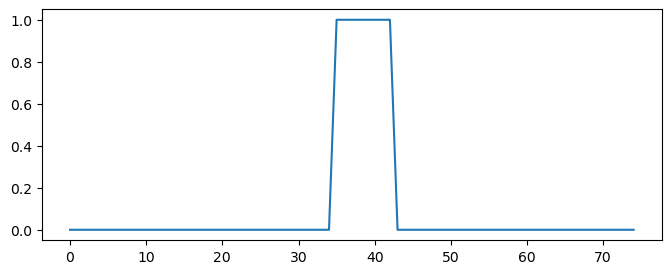

In [24]:
threshold = np.mean(zcrs) + np.std(zcrs)
print(len(es))
# find the maximum energy's index
max_index = np.argmax(es)
quantized = np.zeros(zcrs.shape[1])
for i in range(zcrs[0].size):
    if zcrs[0][i] > threshold:
        quantized[i] = 1
    else: quantized[i] = 0
    
#quantized = scipy.signal.medfilt(quantized, 3)
plt.figure(figsize=FIG_SIZE)
plt.plot(quantized)

In [15]:
max_index2 = int(len(quantized)*max_index/len(es))
print(max_index2)

index_right = max_index2
while quantized[index_right] == 1:
    index_right += 1
index_left = max_index2
while quantized[index_left] == 1:
    index_left -= 1

endindex = int(index_right*len(es)/len(quantized))
startindex = int(index_left*len(es)/len(quantized)) 
print(startindex, endindex)

startpoint = len(signal1)*startindex//len(es)
endpoint = len(signal1)*endindex//len(es)

endpoint_signal = signal1[startpoint:endpoint]
scipy.io.wavfile.write('cropped.wav', Fs, endpoint_signal)

38
3 188


## End of Lab 03